In [1]:
#importing libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm

%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

98


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


'/proj/arivale/snapshots/arivale_snapshot_ISB_2020-03-16_2156'

In [2]:
#read in ASV table
asvs = pd.read_csv("/proj/arivale/microbiome/16S_processed/asvs.csv")

#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#read in taxonomy data
tax = pd.read_csv("/proj/arivale/microbiome/16S_processed/taxonomy.csv")

#load in chemistries snapshot 
chemistries = adi.get_snapshot('chemistries')

#load in lifestyle_assessments snapshot  
lifestyle_assessment = adi.get_snapshot('assessments_raw')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

#import Shannon diversity
shannon_trimmed = adi.get_snapshot('microbiome_trimmed_diversity')
shannon = adi.get_snapshot('microbiome_diversity')


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:271: DeprecationWarning: `assessments_medications` is slated for deprecation and will be part of `assessments` with raw data will be available in `assessments_raw`
  check_deprecation(name) # check if requested snapshot is to be deprecated


In [3]:
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.shape

(5232, 24)

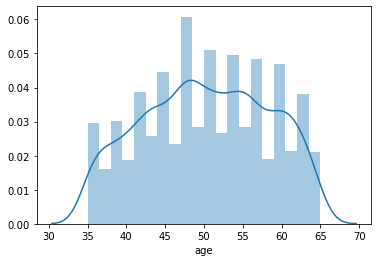

In [4]:
#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=35]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape
sns.distplot(age_filtered_samples['age'])

In [5]:
#filter for baseline samples
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 30]
baseline_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()

#filter for baseline chemistries
bl_chemistries = chemistries[chemistries['days_since_first_draw'].abs() <= 30]

#merge with insulin data
bl_metadata = pd.merge(baseline_samples,bl_chemistries[['public_client_id','INSULIN']],on='public_client_id')

#only include insulin levels above the healthy insulin threshold
bl_metadata = bl_metadata[bl_metadata['INSULIN']>=8]

In [6]:
#rename 'days since first draw' column to 'time point'
bl_metadata = bl_metadata.rename(columns={'days_since_first_draw': 'time point'})
#replace all values in the time point column with 0
bl_metadata['time point'] = np.where(bl_metadata['time point'] <= 30, 0, 
                                                bl_metadata['time point'])

In [7]:
#filter for 6month samples
samples2 = age_filtered_samples.copy(deep=True)
samples2['days_since_first_draw_abs'] = samples2['days_since_first_draw'].abs()
samples2 = samples2[samples2['days_since_first_draw'].abs() <= 360]
sixmonth_samples = samples2[samples2['days_since_first_draw'].abs() >30]
sixmonth_samples = sixmonth_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
sixmonth_samples_ids = sixmonth_samples['id'].values

#merge samples with antibiotics data
sixmonth_noab = pd.merge(sixmonth_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

sixmonth_noab.shape

(995, 27)

In [8]:
#only indlude six month blood draw data for chemistries
baseline_chemistries2 = chemistries.copy(deep=True)
baseline_chemistries2 = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() <= 360]
sixmonth_chemistries = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() >30]
sixmonth_chemistries.shape

#merge with insulin data
sixmonth_metadata = pd.merge(sixmonth_noab,sixmonth_chemistries[['public_client_id','INSULIN']],on='public_client_id')

sixmonth_metadata.shape

(1236, 28)

In [9]:
sixmonth_metadata = sixmonth_metadata.rename(columns={'days_since_first_draw': 'time point'})
sixmonth_metadata['time point'] = np.where(sixmonth_metadata['time point'] <= 360, 6, 
                                                sixmonth_metadata['time point'])

In [10]:
#convert bl_metadata from longform to wide form
bl_long = pd.melt(bl_metadata,id_vars=['public_client_id','time point'],value_vars=['INSULIN'])
bl_long =bl_long.drop(['variable'],axis=1)

In [11]:
#convert sixmonth_metadata from longform to wide form
sixmonth_long = pd.melt(sixmonth_metadata,id_vars=['public_client_id','time point'],value_vars=['INSULIN'])
sixmonth_long =sixmonth_long.drop(['variable'],axis=1)

In [12]:
#combine baseline and sixmonth metadata
bl6mo_long = [bl_long,sixmonth_long]
bl6mo_longdata = pd.concat(bl6mo_long)
bl6mo_longdata = bl6mo_longdata.rename(columns={'value':'Insulin'})

Text(0.5, 1.0, 'Insulin')

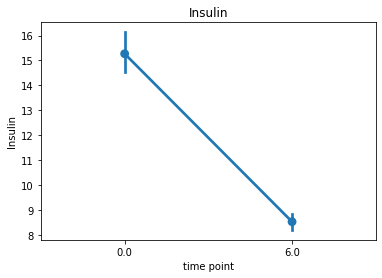

In [13]:
sns.pointplot(x='time point',y='Insulin',data=bl6mo_longdata)
plt.title('Insulin')

In [14]:
#rename 'INSULIN' column to 'BL INSULIN' in bl_metadata2 dataframe
bl_metadata2 = bl_metadata.rename({'time point':'BL_time_point','INSULIN':'BL_INSULIN'},axis=1)
bl_metadata2.shape

(1036, 27)

In [15]:
# rename 'INSULIN' column to '6MO_INSULIN' in sixmonth_metadata2 dataframe
sixmonth_metadata2 = sixmonth_metadata.rename({'time point':'6mo_time_point','INSULIN':'6MO_INSULIN'},axis=1)
sixmonth_metadata2.shape

(1236, 28)

In [16]:
#create dataframe of baseline and 6 month insulin data
bl6mo_metadata = pd.merge(bl_metadata2,sixmonth_metadata2[['public_client_id','6mo_time_point','6MO_INSULIN']],
                          on='public_client_id')
#bl6mo_metadata = bl6mo_metadata['BL_INSULIN'].dropna()
bl6mo_metadata.head()

public_client_id      genome_id genome_vendor multiple_genome_ids  \
0         01005100      DS-293608      WUXI_SNP                 NaN   
1         01006695      DS-291353      WUXI_SNP                 NaN   
2         01012626      DS-291365      WUXI_SNP                 NaN   
3         01012626      DS-291365      WUXI_SNP                 NaN   
4         01013950  A752AT594-004      NEXTCODE                 NaN   

   client_id                               user_id sex   race  \
0   268339.0  ec9e8086-1f28-44e8-81f8-f4732d6bda1c   F  white   
1   253022.0  c17dcc57-022d-483e-b3be-1386820f5e19   M  white   
2   246549.0  f3dfc37c-8857-439c-9382-012379e3693b   M  white   
3   246549.0  f3dfc37c-8857-439c-9382-012379e3693b   M  white   
4      490.0  bbbd0d1f-75f8-4572-96aa-92932e1df47c   F  white   

   has_research_consent        enterprise  ... days_since_first_call  \
0                  True  aac0298a21469db8  ...                   0.0   
1                  True  f1c39fea488575ec  ...                  -7.0   
2                  True  d4cd0dabcf4caa22  ...                  -2.0   
3                  True  d4cd0dabcf4caa22  ...                  -2.0   
4                  True  d4cd0dabcf4caa22  ...                   8.0   

  BL_time_point month weekday                           id  \
0           0.0   Apr     Mon  22001803512697|GFM-1079-024   
1           0.0   Mar     Mon  22001701510224|GFM-1079-022   
2           0.0   Mar     Tue  22001701512014|GFM-1079-021   
3           0.0   Mar     Tue  22001701512014|GFM-1079-021   
4           0.0   Oct     Thu             AV15-1319|AKE009   

   meds_antibiotics_last_3_months  days_since_first_draw_abs BL_INSULIN  \
0                              No                       10.0        9.4   
1                              No                        3.0        9.9   
2                              No                        6.0       17.5   
3                              No                        6.0       17.5   
4                              No                        0.0       10.0   

   6mo_time_point  6MO_INSULIN  
0             6.0         11.7  
1             6.0          7.8  
2             6.0         14.7  
3             6.0         14.7  
4             6.0          6.1  

[5 rows x 29 columns]

In [17]:
# create empty list for change in insulin
Delta = []

# create for loop that 
for row1 in bl6mo_metadata['BL_INSULIN']:
    for row2 in bl6mo_metadata['6MO_INSULIN']:
        Delta.append(row1 - row2)

# absolute value of delta        
Delta_abs = [abs(ele) for ele in Delta]

# add delta column to BL and 6 month metadata
bl6mo_metadata['Delta'] = Delta_abs[0:417]
sns.distplot(bl6mo_metadata['Delta'])

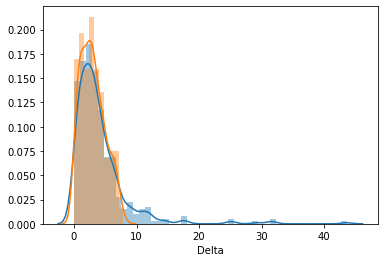

In [18]:
bl6mo_metadata2 = bl6mo_metadata[bl6mo_metadata['Delta']<=8]
sns.distplot(bl6mo_metadata2['Delta'])

In [19]:
bl6mo_metadata2.describe()

client_id         age  days_in_program  days_since_first_call  \
count     374.000000  374.000000       374.000000             374.000000   
mean    50551.417112   51.770053        31.326203              -0.518717   
std     89604.299222    7.844027        24.269610              22.196380   
min       237.000000   35.000000         2.000000             -60.000000   
25%       481.000000   46.000000        14.000000              -8.750000   
50%       669.000000   51.000000        26.000000              -1.000000   
75%      7155.000000   58.750000        41.000000               5.000000   
max    274546.000000   65.000000       161.000000             148.000000   

       BL_time_point  days_since_first_draw_abs  BL_INSULIN  6mo_time_point  \
count          374.0                 374.000000  374.000000           374.0   
mean             0.0                   2.296791   11.799733             6.0   
std              0.0                   5.423130    3.881803             0.0   
min              0.0                   0.000000    8.000000             6.0   
25%              0.0                   0.000000    9.000000             6.0   
50%              0.0                   0.000000   10.300000             6.0   
75%              0.0                   1.000000   13.675000             6.0   
max              0.0                  27.000000   39.000000             6.0   

       6MO_INSULIN       Delta  
count   374.000000  374.000000  
mean      8.502674    2.971658  
std       3.425037    1.919324  
min       1.800000    0.000000  
25%       6.100000    1.400000  
50%       8.000000    2.700000  
75%      10.950000    4.300000  
max      17.300000    7.900000

<ipython-input-20-c98e71ec8c6d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl6mo_metadata2['Responder?'] = Responder[0:374]


Text(0.5, 1.0, 'Insulin: Response to Intervention')

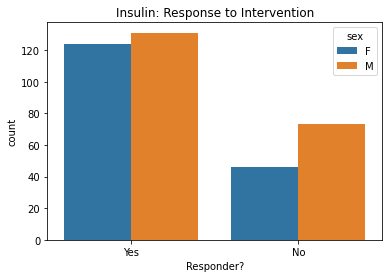

In [20]:
# create empty list for responder data 
Responder = []

for delta in bl6mo_metadata['Delta']: 
        if delta >= 1.91:
            Responder.append('Yes')
        else:
            Responder.append('No')

#for row1 in bl6mo_metadata['6MO_INSULIN']:    
    #if row1 <= 8:
        #Responder.append('Yes')
    #else:
        #Responder.append('No')

#add responder column to BL and 6 month metadata
bl6mo_metadata2['Responder?'] = Responder[0:374]
sns.countplot(x='Responder?',data=bl6mo_metadata2, hue='sex')
plt.title('Insulin: Response to Intervention')

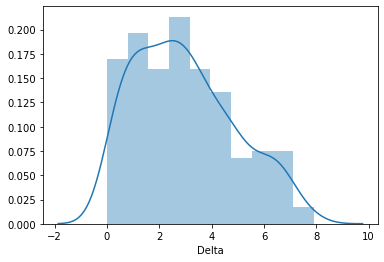

In [21]:
sns.distplot(bl6mo_metadata2['Delta'])

In [22]:
# drop all unecessary columns in metadata dataframe
metadata_compact = bl6mo_metadata2.drop(['genome_id','genome_vendor','coach','multiple_genome_ids','client_id','user_id','race','enterprise',
    'region','country','current_program','latest_program','is_helix','vendor_observation_id','days_in_program',
     'days_since_first_call','month','weekday'],axis=1)
#rename 'id' column to 'sample id'
metadata_compact = metadata_compact.rename({'id':'sample_id'},axis=1)

In [23]:
#merge diversity data to compact metadata
metadata_diversity = pd.merge(metadata_compact,shannon_trimmed[['public_client_id','shannon_50000']],
                                  on='public_client_id')
metadata_diversity.shape

(997, 14)

In [24]:
# load in snapshot with bmi data
BMI = adi.get_snapshot('weight_raw')
BMI_compact = BMI.groupby('public_client_id').mean()
BMI_compact = BMI_compact.reset_index()
BMI_compact.head()

public_client_id  client_id  observation_id  days_in_program  \
0         01000261     1966.0         28708.0            100.0   
1         01000552   280707.0       3700807.6              0.6   
2         01001181   276325.0       2998600.0              0.0   
3         01001298   275178.0       3085690.3             55.8   
4         01001467   274017.0       2469466.0             10.0   

   days_since_first_call  days_since_first_draw        BMI  \
0                   26.0                   35.0  22.852342   
1                    NaN                    NaN  31.519396   
2                    NaN                    NaN  39.047808   
3                   48.8                   48.8  26.163987   
4                   -4.0                   -5.0  18.479394   

   waist_circumference      weight  WEIGHT_CALC  HEIGHT_CALC   BMI_CALC  
0                 32.0  141.600000       141.60         66.0  22.852342  
1                  NaN  252.200000       252.20         75.0  31.519396  
2                  NaN  280.000000       280.00         71.0  39.047808  
3                 34.0  157.244444       157.52         65.0  26.209837  
4                 25.0  118.000000       118.00         67.0  18.479394

In [25]:
# merge with BMI data with metadata_diversity data
metadata_diversity_BMI = pd.merge(metadata_diversity, BMI_compact[['public_client_id','BMI']], 
                                  on='public_client_id')

metadata_diversity_BMI.head()

public_client_id sex  has_research_consent   age  BL_time_point  \
0         01005100   F                  True  48.0            0.0   
1         01005100   F                  True  48.0            0.0   
2         01006695   M                  True  61.0            0.0   
3         01006695   M                  True  61.0            0.0   
4         01012626   M                  True  54.0            0.0   

                     sample_id meds_antibiotics_last_3_months  \
0  22001803512697|GFM-1079-024                             No   
1  22001803512697|GFM-1079-024                             No   
2  22001701510224|GFM-1079-022                             No   
3  22001701510224|GFM-1079-022                             No   
4  22001701512014|GFM-1079-021                             No   

   days_since_first_draw_abs  BL_INSULIN  6mo_time_point  6MO_INSULIN  Delta  \
0                       10.0         9.4             6.0         11.7    2.3   
1                       10.0         9.4             6.0         11.7    2.3   
2                        3.0         9.9             6.0          7.8    1.6   
3                        3.0         9.9             6.0          7.8    1.6   
4                        6.0        17.5             6.0         14.7    5.3   

  Responder?  shannon_50000        BMI  
0        Yes       2.757339  23.078283  
1        Yes       4.453471  23.078283  
2         No       4.312069  21.998639  
3         No       3.977972  21.998639  
4        Yes       4.395246  36.409833

In [26]:
###########################################################################################
# SETTING UP ASV AND TAXONOMY DATA

In [27]:
#convert ASV table to wide form
asvs_wide=pd.pivot_table(asvs,index='id',columns='hash',values='count', fill_value=0)
asvs_wide_baseline = asvs_wide.loc[asvs_wide.index.isin(all_samples_ids)]

In [28]:
#transpose the asv dataframe
asvsT = asvs_wide_baseline.transpose()
asvsT.head()

id                                22001612560009|GFM-1079-007  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560012|GFM-1079-011  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560014|GFM-1079-016  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560015|GFM-1079-015  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560016|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560017|GFM-1079-009  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560020|GFM-1079-003  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560022|GFM-1079-006  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560023|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66

In [29]:
#add index to newly transposed asv_samples data
asvsT_index = asvsT.reset_index()
asvsT_index.head()

id                              hash  22001612560009|GFM-1079-007  \
0   00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1   00018b0d514b0f1a47ce15eaa4d247f6                            0   
2   0001eda93a1e6802360bf98488c24869                            0   
3   0002120f916215b077ef0a08d66d2716                            0   
4   00030c11306e21d37b6746c3bde4bf04                            0   

id  22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                             0                            0  ...   
1                             0                            0  ...   
2                             0                            0  ...   
3                             0                            0  ...   
4                             0                            0  ...   

id  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  FLCK|AKE014  MIFN|AKE014  \
0                  0                 0            0            0            0   
1                  0                 0            0            0            0   
2                  0                 0            0            0            0   
3                  0                 0            0            0            0   
4                  0                 0            0            0            0   

id  MUMA|AKE014  NEBZ-2|AKE016  NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
0             0              0            0              0            0  
1             0              0            0              0            0  
2             0              0            0              0            0  
3             0              0            0              0            0  
4             0              0            0              0            0  

[5 rows x 5233 columns]

In [30]:
#taxonomy data: rename the id column to "index" so it can be merged with the asvsamplesT_index dataframe
tax = tax.rename(columns={'id': 'hash'})
tax.head()

Kingdom         Phylum        Class          Order           Family  \
0  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
1  Bacteria     Firmicutes   Clostridia  Clostridiales  Ruminococcaceae   
2  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   
3  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
4  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   

              Genus      Species  \
0       Bacteroides     vulgatus   
1  Faecalibacterium  prausnitzii   
2      Agathobacter          NaN   
3       Bacteroides          NaN   
4           Blautia          NaN   

                                            sequence  \
0  GCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCC...   
1  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   
2  GCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCG...   
3  GCAGCAGTGAGGAATATTGGTCAATGGGCGATGGCCTGAACCAGCC...   
4  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   

                               hash  
0  c2d3fc09212e226b3a2c3398a1af9436  
1  a425c9ccfd2d87768c9524f0a798ee2d  
2  11e733f60337e5ef6c9a94a66841d20b  
3  7ed48cd35b68995ff96e23b89c9018c5  
4  2582ff55b130be55a786156c3da4dcf8

In [31]:
#merge taxonomy data with asv data
ASV_tax_data = pd.merge(asvsT_index,tax,on='hash')
ASV_tax_data.head()

hash  22001612560009|GFM-1079-007  \
0  00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1  00018b0d514b0f1a47ce15eaa4d247f6                            0   
2  0001eda93a1e6802360bf98488c24869                            0   
3  0002120f916215b077ef0a08d66d2716                            0   
4  00030c11306e21d37b6746c3bde4bf04                            0   

   22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                            0                            0  ...   
1                            0                            0  ...   
2                            0                            0  ...   
3                            0                            0  ...   
4                            0                            0  ...   

   QIRL-2|AKE014  QIRL|AKE014   Kingdom         Phylum        Class  \
0              0            0  Bacteria     Firmicutes   Clostridia   
1              0            0  Bacteria  Bacteroidetes  Bacteroidia   
2              0            0  Bacteria     Firmicutes   Clostridia   
3              0            0  Bacteria     Firmicutes   Clostridia   
4              0            0  Bacteria     Firmicutes   Clostridia   

           Order               Family                          Genus  Species  \
0  Clostridiales      Lachnospiraceae                   Anaerostipes      NaN   
1  Bacteroidales       Muribaculaceae                            NaN      NaN   
2  Clostridiales  Christensenellaceae  Christensenellaceae_R-7_group      NaN   
3  Clostridiales      Ruminococcaceae                            NaN      NaN   
4  Clostridiales      Ruminococcaceae                         DTU089      NaN   

                                            sequence  
0  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...  
1  GCAGCAGTGAGGAATATTGGTCAATGGGCGGGAGCCTGAACCAGCC...  
2  GCAGCAGTGGGGAATATTGGGCAATGGGCGAAAGCCTGACCCAGCA...  
3  GCTGCAGTGGGGGATATTGCACAATGGGGGAAACCCTGATGCAGCA...  
4  GCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGA...  

[5 rows x 5241 columns]

In [32]:
#drop the sequence column
ASV_tax_data = ASV_tax_data.drop(['sequence'],axis=1)

In [33]:
#fill NaN values with 0
ASV_tax_data.fillna(0)

hash  22001612560009|GFM-1079-007  \
0      00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1      00018b0d514b0f1a47ce15eaa4d247f6                            0   
2      0001eda93a1e6802360bf98488c24869                            0   
3      0002120f916215b077ef0a08d66d2716                            0   
4      00030c11306e21d37b6746c3bde4bf04                            0   
...                                 ...                          ...   
89017  fffa9d186997056849b930a68dd8b121                            0   
89018  fffbae09f8a62b3498565b4fe8838846                            0   
89019  fffc51faa053251845837ffc43231b30                            0   
89020  fffe4057d41c6ef3b16a370498eb01a9                            0   
89021  ffff9eed68c63035d7f56c61d7603794                            0   

       22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                                0                            0  ...   
1                                0                            0  ...   
2                                0                            0  ...   
3                                0                            0  ...   
4                                0                            0  ...   
...                            ...                          ...  ...   
89017                            0                            0  ...   
89018                            0                            0  ...   
89019                            0                            0  ...   
89020                            0 

In [34]:
#sum on genus level
genus_counts = ASV_tax_data.groupby(["Genus"]).sum()
#genus_counts.head()

In [35]:
#NORMALIZING DATA

# set genera where total reads for that genera across all samples is < 10
genus_counts_filtered = genus_counts[genus_counts >= 10].fillna(0)

# filter for only genera where abundance > 0
genus_counts_filtered = genus_counts_filtered.loc[genus_counts_filtered.sum(axis=1) > 0,:] 

# filter for samples where the sequencing depth is > 50,000
genus_counts_filtered = genus_counts_filtered.loc[:,genus_counts_filtered.sum() >= 50000]

#normalizing to relative abundance: (count of genus X)/(total count in a sample)
normalized_counts = genus_counts_filtered/genus_counts_filtered.sum()
normalized_counts.head()

22001612560009|GFM-1079-007  22001612560012|GFM-1079-011  \
Genus                                                                           
28-4                                    0.000000                     0.000000   
A2                                      0.000000                     0.000000   
ASF356                                  0.000000                     0.000000   
Abiotrophia                             0.000000                     0.000000   
Acetanaerobacterium                     0.000295                     0.000168   

                     22001612560014|GFM-1079-016  22001612560015|GFM-1079-015  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     22001612560016|GFM-1079-001  22001612560017|GFM-1079-009  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     22001612560020|GFM-1079-003  22001612560022|GFM-1079-006  \
Genus                                                                           
28-4                                         0.0                     0.000000   
A2                                           0.0                     0.000000   
ASF356                                       0.0                     0.000000   
Abiotrophia                                  0.0                     0.000000   
Acetanaerobacterium                          0.0                     0.000114   

                     22001612560023|GFM-1079-001  22001612560027|GFM-1079-003  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     ...  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  \
Genus                ...                                                    
28-4                 ...               0.0          0.009445          0.0   
A2                   ...               0.0          0.000000          0.0   
ASF356               ...               0.0          0.000000          0.0   
Abiotrophia          ...               0.0          0.000000          0.0   
Acetanaerobacterium  ...               0.0          0.000000          0.0   

                     FLCK|AKE014  MIFN|AKE014  MUMA|AKE014  NEBZ-2|AKE016  \
Genus                                                                       
28-4                    0.010792          0.0          0.0       0.000000   
A2                      0.000000          0.0          0.0       0.000000   
ASF356                  0.000000          0.0          0.0       0.000000   
Abiotrophia             0.000000          0.0          0.0       0.000000   
Acetanaerobacterium     0.000000          0.0          0.0       0.000444   

                     NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
Genus                                 

In [38]:
######################################################################
# CALCULATING CENTER LOG RATIO FOR ALL DATA

In [39]:
from skbio.stats.composition import clr

In [40]:
# add pseudocount because CLR transform requires that you have non-zero abundances 
normalizedT = skbio.stats.composition.multiplicative_replacement(normalized_counts.T)

# Perform CLR transformation
# https://www.ars.usda.gov/ARSUserFiles/80800505/International%20Workshop/Presentations/Wednesday%20Morning/Adam%20Rivers.pdf

clr_data = skbio.stats.composition.clr(normalizedT)
clr_data = pd.DataFrame(clr_data, 
                        columns = normalized_counts.index, 
                        index = normalized_counts.columns)
clr_data.describe()

Genus         28-4           A2       ASF356  Abiotrophia  \
count  5127.000000  5127.000000  5127.000000  5127.000000   
mean     -0.849100    -1.129673    -1.129685    -1.123811   
std       1.295912     0.233146     0.233729     0.274878   
min      -1.786739    -1.786739    -1.786739    -1.786739   
25%      -1.278667    -1.291326    -1.291526    -1.291326   
50%      -1.127524    -1.148522    -1.148522    -1.148451   
75%      -0.957386    -0.996405    -0.996405    -0.996169   
max       7.899725     1.406389     1.649431     3.664560   

Genus  Acetanaerobacterium  Acetatifactor  Acetitomaculum  Acidaminococcus  \
count          5127.000000    5127.000000     5127.000000      5127.000000   
mean             -0.724227      -1.123842       -1.122209        -0.180443   
std               1.084349       0.282713        0.318152         2.267768   
min              -1.786739      -1.786739       -1.786739        -1.786739   
25%              -1.258029      -1.291071       -1.290725        -1.258122   
50%              -1.099106      -1.148309       -1.148309        -1.093412   
75%              -0.875416      -0.996095       -0.996095        -0.834818   
max               5.047864       4.668521        6.534634         9.112541   

Genus  Acidipropionibacterium   Acidovorax  ...   Vagococcus  Varibaculum  \
count             5127.000000  5127.000000  ...  5127.000000  5127.000000   
mean                -1.129760    -1.129500  ...    -1.128969    -1.060198   
std                  0.233154     0.237183  ...     0.237695     0.578220   
min                 -1.786739    -1.786739  ...    -1.766855    -1.786739   
25%                 -1.291526    -1.291526  ...    -1.291162    -1.286211   
50%                 -1.148549    -1.148549  ...    -1.148461    -1.140875   
75%                 -0.996405    -0.996509  ...    -0.996363    -0.981761   
max                  1.391923     2.886871  ...     2.941162     7.943800   

Genus  Veillonella  Victivallis        W5053    Weissella      XBB1006  \
count  5127.000000  5127.000000  5127.000000  5127.000000  5127.000000   
mean      0.831442     0.006455    -1.126497    -0.994358    -1.125714   
std       2.319068     1.972236     0.253588     0.795348     0.259099   
min      -1.786739    -1.695990    -1.786739    -1.766855    -1.786739   
25%      -1.179655    -1.186110    -1.291071    -1.284744    -1.290936   
50%      -0.767629    -1.003880    -1.148381    -1.137198    -1.148309   
75%       2.699364    -0.200570    -0.996169    -0.972357    -0.996095   
max       9.264536     6.473605     3.097554     7.195113     3.694134   

Genus     Yersinia          Z20  dgA-11_gut_group  
count  5127.000000  5127.000000       5127.000000  
mean     -1.128092    -1.108502         -1.122341  
std       0.248810     0.440411          0.305534  
min      -1.786739    -1.786739         -1.786739  
25%      -1.291326    -1.290155         -1.290725  
50%      -1.148522    -1.147359         -1.148309  
75%      -0.996363    -0.994800         -0.996095  
max       4.363920     7.315159          5.869644  

[8 rows x 421 columns]

In [41]:
#reset index of clr data and rename index column to 'sample_id'
clr_reset = clr_data.reset_index().rename(columns={'index':'sample_id'})
#clr_reset.head()

In [42]:
#merge compact metadata with clr_data and shannon diversity
clr_metadata_all = pd.merge(clr_reset,metadata_diversity_BMI,on='sample_id')
#clr_metadata_all = clr_metadata_all.groupby('sample_id').mean()
#clr_metadata_all = clr_metadata_all.reset_index()
clr_metadata_all.shape

(989, 436)

In [43]:
# create smaller dataframe of responder baseline gut microbiome
responder_microbiome = clr_metadata_all[clr_metadata_all['Responder?']=='Yes']
responder_microbiome.shape

(679, 436)

In [44]:
# create smaller dataframe of non-responder baseline gut microbiome
nonresponder_microbiome = clr_metadata_all[clr_metadata_all['Responder?']=='No']
nonresponder_microbiome.shape

(310, 436)

In [45]:
#Perform Mann-Whitney U Test
import scipy.stats as stats

In [46]:
# QUESTION to answer: are the bacteroides population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_bacteroides_list = [];
for ele in responder_microbiome['Bacteroides']:
        responder_bacteroides_list.append(ele)
        
# convert responder list to array 
responder_bacteroides_array = np.array(responder_bacteroides_list)

# for loop that stores all non-responders in a list 
nonresponder_bacteroides_list = [];
for ele in nonresponder_microbiome['Bacteroides']:
        nonresponder_bacteroides_list.append(ele)
    
# convert non-responder list to array
nonresponder_bacteroides_array = np.array(nonresponder_bacteroides_list)

# calculate u and the probability of a difference
u_statistic, pVal1 = stats.mannwhitneyu(responder_bacteroides_array,nonresponder_bacteroides_array)
print(pVal1)

0.09917945170085779


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/scipy/stats/stats.py:6388: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  warnings.warn("Calling `mannwhitneyu` without specifying "


In [47]:
# QUESTION to answer: are the prevotella population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_prevotella_list = [];
for ele in responder_microbiome['Prevotella']:
        responder_prevotella_list.append(ele)
        
# convert responder list to array 
responder_prevotella_array = np.array(responder_prevotella_list)

# for loop that stores all non-responders in a list 
nonresponder_prevotella_list = [];
for ele in nonresponder_microbiome['Prevotella']:
        nonresponder_prevotella_list.append(ele)
    
# convert non-responder list to array
nonresponder_prevotella_array = np.array(nonresponder_prevotella_list)

# calculate u and the probability of a difference
u_statistic, pVal2 = stats.mannwhitneyu(responder_prevotella_array,nonresponder_prevotella_array)
print(pVal2)

0.1614759046651475


In [46]:
# QUESTION to answer: are the ruminococcus population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_ruminococcus_list = [];
for ele in responder_microbiome['Ruminococcus_1']:
        responder_ruminococcus_list.append(ele)
        
# convert responder list to array 
responder_ruminococcus_array = np.array(responder_ruminococcus_list)

# for loop that stores all non-responders in a list 
nonresponder_ruminococcus_list = [];
for ele in nonresponder_microbiome['Ruminococcus_1']:
        nonresponder_ruminococcus_list.append(ele)
    
# convert non-responder list to array
nonresponder_ruminococcus_array = np.array(nonresponder_ruminococcus_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_ruminococcus_array,nonresponder_ruminococcus_array)
print(pVal3)

0.3988085400184348


In [48]:
# QUESTION to answer: are the bifidobacterium levels after 6 months significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_bifidobacterium_list = [];
for ele in responder_microbiome['Bifidobacterium']:
        responder_bifidobacterium_list.append(ele)
        
# convert responder list to array 
responder_bifidobacterium_array = np.array(responder_bifidobacterium_list)

# for loop that stores all non-responders in a list 
nonresponder_bifidobacterium_list = [];
for ele in nonresponder_microbiome['Bifidobacterium']:
        nonresponder_bifidobacterium_list.append(ele)
    
# convert non-responder list to array
nonresponder_bifidobacterium_array = np.array(nonresponder_bifidobacterium_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_bifidobacterium_array,nonresponder_bifidobacterium_array)
print(pVal3)

0.0012944644389759942


In [49]:
# QUESTION to answer: is shannon diversity significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_ruminococcus_list = [];
for ele in responder_microbiome['shannon_50000']:
        responder_ruminococcus_list.append(ele)
        
# convert responder list to array 
responder_ruminococcus_array = np.array(responder_ruminococcus_list)

# for loop that stores all non-responders in a list 
nonresponder_ruminococcus_list = [];
for ele in nonresponder_microbiome['shannon_50000']:
        nonresponder_ruminococcus_list.append(ele)
    
# convert non-responder list to array
nonresponder_ruminococcus_array = np.array(nonresponder_ruminococcus_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_ruminococcus_array,nonresponder_ruminococcus_array)
print(pVal3)

0.43778720000958776


In [50]:
###################################
#LOGISTIC REGRESSION VIA SKLEARN

In [51]:
# create a dummy variable for Responder column in clr_metadata_all table (responder=1)
responder_ml = pd.get_dummies(clr_metadata_all['Responder?'],drop_first=True)

# create a dummy variable for Sex column in clr_metadata_all (female=1)
gender_ml = pd.get_dummies(clr_metadata_all['sex'],drop_first=True)

# concatenate the dummy variable table with the 
ml_data = pd.concat([clr_metadata_all,responder_ml,gender_ml],axis=1)
#list(ml_data.columns)

In [52]:
# drop non-numerical columns
ml_data.drop(['sample_id','public_client_id','has_research_consent','meds_antibiotics_last_3_months',
 'days_since_first_draw_abs','BL_INSULIN','6mo_time_point','BL_time_point','6MO_INSULIN','sex',
              'Delta','Responder?'],axis=1,inplace=True)
ml_microbiome = ml_data.rename({'Yes':'Responder','M':'Gender'},axis=1).dropna()
ml_microbiome.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  \
0   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
1   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
2   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
3   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
4   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   

    age  shannon_50000        BMI  Responder  Gender  
0  57.0       3.664669  28.426865          1       0  
1  57.0       3.104606  28.426865          1       0  
2  49.0       4.416041  29.780550          0       1  
3  49.0       3.788742  29.780550          0       1  
4  49.0       4.416041  29.780550          0       1  

[5 rows x 426 columns]

In [53]:
#separate X and y variables. y is what you are trying to predict, which in this case is whether a participant is a 
#responder or not

X = ml_microbiome.drop(['Responder'],axis=1)
y = ml_microbiome['Responder']

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
#create an instance of logistic regression
logmodel = LogisticRegression()

In [58]:
#fit the model
logmodel.fit(X_train,y_train)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
predictions = logmodel.predict(X_test)

In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.51      0.63      0.57        86
           1       0.83      0.76      0.79       211

    accuracy                           0.72       297
   macro avg       0.67      0.69      0.68       297
weighted avg       0.74      0.72      0.73       297



In [62]:
from sklearn.metrics import confusion_matrix

Text(0.5, 257.44, 'Predicted Label')

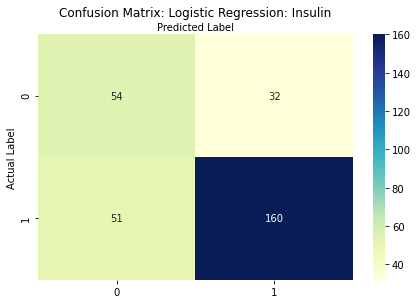

In [63]:
# confusion matrix
cnf_matrix_lr = confusion_matrix(y_test,predictions)
cnf_matrix_lr
# visualizing confusion matrix using heat map

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heat map
sns.heatmap(pd.DataFrame(cnf_matrix_lr),annot=True,cmap="YlGnBu",fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: Logistic Regression: Insulin',y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


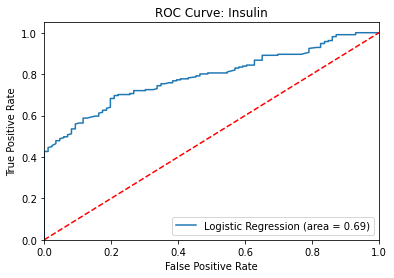

In [64]:
# creating an ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Insulin')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [121]:
logreg_metadata= clr_metadata_div.drop(['sample_id','public_client_id','sex','has_research_consent',
 'age','BL_time_point','meds_antibiotics_last_3_months','days_since_first_draw_abs',
 'BL_INSULIN','6mo_time_point','6MO_INSULIN','Delta'],axis=1)

In [127]:
logreg_metadata.rename({'Responder?':'Responder'},axis=1)

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0   -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1   -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2   -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3   -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4   -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
..        ...       ...       ...          ...                  ...   
984 -1.128042 -1.128042 -1.128042    -1.128042            -1.128042   
985 -0.662262 -0.662262 -0.662262    -0.662262            -0.662262   
986 -0.662262 -0.662262 -0.662262    -0.662262            -0.662262   
987 -1.107098 -1.107098 -1.107098    -1.107098            -1.107098   
988 -1.107098 -1.107098 -1.107098    -1.107098            -1.107098   

     Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0        -0.812026       -0.812026        -0.812026               -0.812026   
1        -0.812026       -0.812026        -0.812026               -0.812026   
2        -1.418771       -1.418771        -1.418771               -1.418771   
3        -1.418771       -1.418771        -1.418771               -1.418771   
4        -1.418771       -1.418771        -1.418771               -1.418771   
..             ...             ...              ...                     ...   
984      -1.128042       -1.128042        -1.128042               -1.128042   
985      -0.662262       -0.662262         5.417113               -0.662262   
986      -0.662262       -0.662262         5.417113               -0.662262   
987      -1.107098       -1.107098         3.766190               -1.107098   
988      -1.107098       -1.107098         3.766190               -1.107098   

     Acidovorax  ...  Veillonella  Victivallis     W5053  Weissella   XBB1006  \
0     -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
1     -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
2     -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
3     -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
4     -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
..          ...  ...          ...          ...       ...        ...       ...   
984   -1.128042  ...    -1.128042    -1.128042 -1.128042  -1.128042 -1.128042   
985   -0.662262  ...    -0.662262    -0.662262 -0.662262  -0.662262 -0.662262   
986   -0.662262  ...    -0.662262    -0.662262 -0.662262  -0.662262 -0.662262   
987   -1.107098  ...     3.098361    -1.107098 -1.107098  -1.107098 -1.107098   
988   -1.107098  ...     3.098361    -1.107098 -1.107098  -1.107098 -1.107098   

     Yersinia       Z20  dgA-11_gut_group  Responder  shannon_50000  
0   -0.812026 -0.812026         -0.812026        Yes       3.664669  
1   -0.812026 -0.812026         -0.812026        Yes       3.104606  
2   -1.418771 -1.418771         -1.418771         No       4.416041  
3   -1.418771 -1.418771         -1.418771         No       3.788742  
4   -1.418771 -1.418771         -1.418771         No       4.416041  
..        ...       ...               ...        ...            ...  
984 -1.128042 -1.128042         -1.128042         No       4.224732  
985 -0.662262 -0.662262         -0.662262        Yes       3.221748  
986 -0.662262 -0.662262         -0.662262        Yes       2.358780  
987 -1.107098 -1.107098         -1.107098        Yes       4.074319  
988 -1.107098 -1.107098         -1.107098        Yes       4.370986  

[989 rows x 423 columns]

In [66]:
#####################################
# LOGISTIC REGRESSION VIA STATS MODEL

In [67]:
ml_microbiome['intercept']=1.0

In [68]:
ml_microbiome.shape

(989, 427)

In [69]:
import statsmodels.formula.api as smf

In [70]:
m1 = smf.logit(formula='Responder ~ Bacteroides+Prevotella+Bifidobacterium+Ruminococcus_1+age+Gender+BMI',
               data=ml_microbiome).fit()

Optimization terminated successfully.
         Current function value: 0.609028
         Iterations 5


In [69]:
print(m1.summary())

                           Logit Regression Results                           
Dep. Variable:              Responder   No. Observations:                  989
Model:                          Logit   Df Residuals:                      981
Method:                           MLE   Df Model:                            7
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                 0.02059
Time:                        15:58:34   Log-Likelihood:                -602.33
converged:                       True   LL-Null:                       -614.99
Covariance Type:            nonrobust   LLR p-value:                 0.0006644
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4625      0.826      1.771      0.076      -0.156       3.081
Bacteroides        -0.0678      0.059     -1.151      0.250      -0.183       0.048
Prevotella          0.1195      

In [71]:
print("Coefficeients")
print(m1.params)
print()
print("p-Values")
print(m1.pvalues)
print()
print("Dependent variables")
print(m1.model.endog_names)

Coefficeients
Intercept          1.462458
Bacteroides       -0.067810
Prevotella         0.119524
Bifidobacterium    0.046871
Ruminococcus_1     0.038374
age               -0.008822
Gender            -0.321645
BMI                0.010020
dtype: float64

p-Values
Intercept          0.076500
Bacteroides        0.249597
Prevotella         0.214797
Bifidobacterium    0.030846
Ruminococcus_1     0.140165
age                0.329684
Gender             0.029438
BMI                0.520469
dtype: float64

Dependent variables
Responder


In [75]:
####################################
# RIDGE REGRESSION (FEATURE SELECTION)

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
from sklearn.linear_model import Ridge

In [78]:
ridge=Ridge()

In [79]:
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}

In [80]:
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=5)

In [81]:
X_rl = X.copy()

In [82]:
y_rl = y.values.reshape(-1,1)

In [83]:
ridge_regressor.fit(X_rl,y_rl)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.02403e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.77595e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.084e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31006e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/skl

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [84]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 20}
-0.4146989449367397


In [85]:
##############################################
# LASSO REGRESSION (FEATURE SELECTION)

In [86]:
from sklearn.linear_model import Lasso

In [87]:
lasso = Lasso()

In [88]:
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}

In [89]:
lasso_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=5)

In [90]:
lasso_regressor.fit(X_rl,y_rl)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.02403e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.77595e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.084e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31006e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/skl

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [92]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 20}
-0.4146989449367397


In [91]:
#######################################
# FEATURE SELECTION USING REGULARIZATION

In [92]:
X_train.shape

(692, 425)

In [93]:
X_test.shape

(297, 425)

In [94]:
#standardize everything to the same scale
from sklearn.preprocessing import StandardScaler

In [95]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [96]:
from sklearn.feature_selection import SelectFromModel

In [97]:
sel_=SelectFromModel(LogisticRegression(C=1,penalty='l2'))

In [98]:
sel_.fit(scaler.transform(X_train.fillna(0)),y_train)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelectFromModel(estimator=LogisticRegression(C=1))

In [99]:

selected_feat = X_train.columns[(sel_.get_support())]

In [100]:
print('total features: {}'.format((X_train.shape[1])))
print('selected_feat: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_==0)))

total features: 425
selected_feat: 157
features with coefficients shrank to zero: 0


In [101]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape

((692, 157), (297, 157))

In [102]:
X_train_selected

array([[ 4.80539826, -1.32563714, -1.32563714, ..., -1.32563714,
        -1.32563714, 20.20058574],
       [ 5.41227075, -1.13621404, -1.13621404, ..., -1.13621404,
        -1.13621404, 22.39025908],
       [-1.15859486, -1.15859486,  2.64147939, ..., -1.15859486,
        -1.15859486, 24.78241791],
       ...,
       [-0.99659362, -0.99659362, -0.99659362, ..., -0.99659362,
        -0.99659362, 30.35719061],
       [ 6.62155389, -1.37236497, -1.37236497, ..., -1.37236497,
        -1.37236497, 23.84418807],
       [-1.48302475, -1.48302475, -1.48302475, ..., -1.48302475,
        -1.48302475, 24.7980307 ]])

In [103]:
important_feat = clr_metadata_all[['28-4','Acetatifactor','Acidaminococcus','Actinomyces','Adlercreutzia',
 'Akkermansia','Alistipes','Allisonella','Alloprevotella','Anaerofilum','Anaerofustis','Anaerostipes',
 'Anaerovorax','Arcobacter','Asteroleplasma','Atopobium','Barnesiella','Bilophila','Blautia',
 'Butyricicoccus','Butyricimonas','Butyrivibrio','CAG-352','CAG-56','Caldicoprobacter',
 'Candidatus_Methanogranum','Candidatus_Soleaferrea','Candidatus_Stoquefichus','Caproiciproducens',
 'Catabacter','Catenibacterium','Cellulosilyticum','Cerasicoccus','Christensenellaceae_R-7_group',
 'Cloacibacillus','Clostridium_sensu_stricto_1','Coprococcus_1','Coprococcus_3','Corynebacterium',
 'Corynebacterium_1','Cuneatibacter','DNF00809','DTU089','Defluviitaleaceae_UCG-011','Denitrobacterium',
 'Dialister','Dielma','Dysgonomonas','Eggerthella','Elusimicrobium','Enterobacter','Enterococcus',
 'Epulopiscium','Erysipelotrichaceae_UCG-003','Erysipelotrichaceae_UCG-004','Escherichia/Shigella',
 'Eubacterium','FD2005','Faecalibacterium','Faecalibaculum','Faecalicoccus','Faecalitalea',
 'Family_XIII_AD3011_group','Family_XIII_UCG-001','Finegoldia','Flavonifractor','Fournierella',
 'Fusicatenibacter','Fusobacterium','GCA-900066225','Gardnerella','Gemella','Gordonibacter',
 'Haemophilus','Harryflintia','Herbinix','Howardella','Hungatella','Hydrogenoanaerobacterium',
 'Intestinimonas','Kandleria','Lachnoclostridium','Lachnoclostridium_5','Lachnospira',
 'Lachnospiraceae_AC2044_group','Lachnospiraceae_FCS020_group','Lachnospiraceae_NC2004_group',
 'Lachnospiraceae_ND3007_group','Lachnospiraceae_UCG-001','Lachnospiraceae_UCG-002',
 'Lachnospiraceae_UCG-010','Lactococcus','Lactonifactor','Libanicoccus','Mailhella','Mannheimia',
 'Megamonas','Muribaculum','Negativibacillus','Odoribacter','Olsenella','Oscillospira','Paeniclostridium',
 'Papillibacter','Paraprevotella','Parvimonas','Peptoclostridium','Peptostreptococcus','Phocea',
 'Prevotella_2','Prevotella_6','Prevotellaceae_Ga6A1_group','Prevotellaceae_UCG-001','Prevotellaceae_UCG-004',
 'Pseudoflavonifractor','Pseudomonas','Pygmaiobacter','Pyramidobacter','Raoultella',
 'Raoultibacter','Rhodanobacter','Rikenellaceae_RC9_gut_group','Robinsoniella','Roseburia','Rothia',
 'Ruminiclostridium_1','Ruminiclostridium_9','Ruminococcaceae_NK4A214_group','Ruminococcaceae_UCG-002',
 'Ruminococcaceae_UCG-003',
 'Ruminococcaceae_UCG-004',
 'Ruminococcaceae_UCG-005',
 'Ruminococcaceae_UCG-007',
 'Ruminococcaceae_UCG-010',
 'Ruminococcaceae_UCG-013',
 'Ruminococcaceae_UCG-014',
 'Ruminococcaceae_V9D2013_group',
 'Ruminococcus_1',
 'Senegalimassilia',
 'Slackia',
 'Staphylococcus',
 'Stomatobaculum',
 'Subdoligranulum',
 'Succiniclasticum',
 'Succinivibrio',
 'Sutterella',
 'Syntrophococcus',
 'Terrisporobacter',
 'Tyzzerella',
 'Tyzzerella_3',
 'Tyzzerella_4',
 'UC5-1-2E3',
 'Varibaculum','Veillonella','Weissella','Z20','BMI','Responder?']].copy()

In [104]:
###########################
# RUNNING ANOTHER LINEAR REGRESSION ON IMPORTANT FEATURES VIA STATS MODEL

In [105]:
important_feat.shape

(989, 158)

In [106]:
# create a dummy variable for Responder column in clr_metadata_all table (responder=1)
responder_ml2 = pd.get_dummies(important_feat['Responder?'],drop_first=True)


# concatenate the dummy variable table with the 
ml_data2 = pd.concat([important_feat,responder_ml2],axis=1)
#list(ml_data.columns)
ml_data2 = ml_data2.drop(['Responder?'],axis=1)
ml_data2 = ml_data.rename(columns={'Yes':'Responder'})

In [107]:
ml_data2.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  \
0   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
1   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
2   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
3   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
4   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   

    age  shannon_50000        BMI  Responder  M  
0  57.0       3.664669  28.426865          1  0  
1  57.0       3.104606  28.426865          1  0  
2  49.0       4.416041  29.780550          0  1  
3  49.0       3.788742  29.780550          0  1  
4  49.0       4.416041  29.780550          0  1  

[5 rows x 426 columns]

In [108]:
important_feat['intercept']=1.0

In [109]:
m2 = smf.logit(formula='Responder ~ Acetatifactor+Acidaminococcus+Actinomyces+Adlercreutzia+BMI',
               data=ml_data2).fit()
m3 = smf.logit(formula='Responder ~ Akkermansia+Alistipes+Allisonella+Alloprevotella+Anaerofilum+Anaerofustis+Anaerostipes+Anaerovorax', 
               data=ml_data2).fit()

Optimization terminated successfully.
         Current function value: 0.609893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606229
         Iterations 5


In [110]:
print(m2.summary())

                           Logit Regression Results                           
Dep. Variable:              Responder   No. Observations:                  989
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Aug 2020   Pseudo R-squ.:                 0.01920
Time:                        10:47:24   Log-Likelihood:                -603.18
converged:                       True   LL-Null:                       -614.99
Covariance Type:            nonrobust   LLR p-value:                 0.0002574
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9759      0.514      1.900      0.057      -0.031       1.983
Acetatifactor       0.3345      0.281      1.192      0.233      -0.215       0.884
Acidaminococcus    -0.0229      

In [111]:
print(m3.summary())

                           Logit Regression Results                           
Dep. Variable:              Responder   No. Observations:                  989
Model:                          Logit   Df Residuals:                      980
Method:                           MLE   Df Model:                            8
Date:                Mon, 03 Aug 2020   Pseudo R-squ.:                 0.02509
Time:                        10:47:26   Log-Likelihood:                -599.56
converged:                       True   LL-Null:                       -614.99
Covariance Type:            nonrobust   LLR p-value:                 0.0001487
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1971      0.711      0.277      0.782      -1.197       1.591
Akkermansia        0.0240      0.025      0.978      0.328      -0.024       0.072
Alistipes         -0.0131      0.035

In [122]:
ml_data2.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  \
0   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
1   -0.812026  ...  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026   
2   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
3   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   
4   -1.418771  ...  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771   

    age  shannon_50000        BMI  Responder  M  
0  57.0       3.664669  28.426865          1  0  
1  57.0       3.104606  28.426865          1  0  
2  49.0       4.416041  29.780550          0  1  
3  49.0       3.788742  29.780550          0  1  
4  49.0       4.416041  29.780550          0  1  

[5 rows x 426 columns]

In [132]:
X2 = ml_data2.drop(['Responder'],axis=1)
y2 = ml_data2['Responder']

In [ ]:
from sklearn.model_selection import train_test_split

In [124]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=101)

In [125]:
#create an instance of logistic regression
logmodel2 = LogisticRegression()

In [133]:
#fit the model
logmodel.fit(X_train2,y_train2)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [134]:
predictions2 = logmodel.predict(X_test2)

In [ ]:
from sklearn.metrics import classification_report

In [135]:
print(classification_report(y_test2,predictions2))

              precision    recall  f1-score   support

           0       0.51      0.63      0.57        86
           1       0.83      0.76      0.79       211

    accuracy                           0.72       297
   macro avg       0.67      0.69      0.68       297
weighted avg       0.74      0.72      0.73       297



In [ ]:
from sklearn.metrics import confusion_matrix

Text(0.5, 257.44, 'Predicted Label')

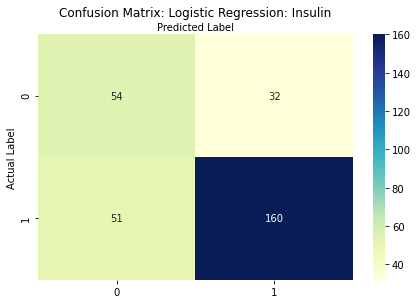

In [129]:
# confusion matrix
cnf_matrix_lr = confusion_matrix(y_test,predictions)
cnf_matrix_lr
# visualizing confusion matrix using heat map

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heat map
sns.heatmap(pd.DataFrame(cnf_matrix_lr),annot=True,cmap="YlGnBu",fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: Logistic Regression: Insulin',y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

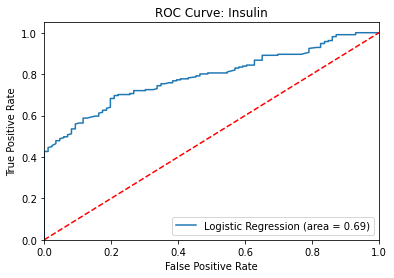

In [131]:
# creating an ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test2, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Insulin')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()